In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import mlflow
import optuna
import os

from TMDP import TMDP
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *

from FrozenLake import *
from CurriculumPMPO import CurriculumPMPO

In [2]:
is_slippery = False
reward_shape = False
dense_reward = True
num_bins = 7
nrows = 10

num_runs = 10
episodes = 4900000
checkpoint_step=500
test_episodes = 1000

shape_range=(-1,0)
goal_reward = 1.
debug = False
param_decay=True

lam = 1
experiment_results = []
exp_taus = []
tests_returns = []
tests_lens = []

In [3]:
if num_bins == 0:
    reward_shape = dense_reward = False
    discount_tau = True
else:
    reward_shape = dense_reward = True
    discount_tau = False

In [4]:
#Frozen Lake Environment
tau = 0.2
nS = nrows**2
nA = 4
gamma = 0.99999999
xi = np.ones(nS) * 1/nS

In [5]:
pol_lr = 0.215723
model_lr = 0.373715
temp = 36.039501
entropy_coef = 0.0010124439030950623
epochs = 3
batch_size = 20
final_temp=1

check_convergence = True
eps_shift = 1e-3 #1.5 best
max_eps_model = 0.5*eps_shift
eps_ppo = 0.2

In [6]:
run_name = f"CurrPMPO_{num_bins}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_name = f"FrozenLake_{nrows}x{nrows}_{num_bins}"
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

save_path = f"results/{experiment_name}/run_{run_name}"
label = run_name.split("_")[0]

In [7]:
def run_experiment(index, seed, run_name, change_map=False):
    sub_run_name = f"{run_name}_{index}"
    
    with mlflow.start_run(nested=True, run_name=sub_run_name):
        # Environment specific configuration   
        map_seed = seed if change_map else constants.SEEDS[0]
        set_policy_seed(seed)
        env = FrozenLakeEnv(is_slippery=is_slippery, seed=seed, 
                        desc=generate_random_map(nrows, seed=map_seed), 
                        reward_shape=reward_shape,
                        num_bins=num_bins,
                        dense_reward=dense_reward,
                        shape_range=shape_range,
                        goal_reward=goal_reward,
                        )
        
        # Environment independent configuration
        tmdp = TMDP(env, xi, tau=tau, 
                    gamma=gamma, discount_tau=discount_tau,
                    seed=seed)
        tmdp.update_tau(tau)
        curr_PMPO = CurriculumPMPO(tmdp, checkpoint_step=checkpoint_step)

        curr_PMPO.train(model_lr, pol_lr, batch_size=batch_size, 
                lam=lam, temp=temp, final_temp=final_temp,
                episodes=episodes, eps_ppo=eps_ppo,
                eps_shift=eps_shift,
                param_decay=param_decay, epochs=epochs, max_length=1000,
                entropy_coef=entropy_coef, debug=debug,
                max_eps_model=max_eps_model, check_convergence=check_convergence)
        
        
        avg_return = np.average(curr_PMPO.reward_records[-10:])/batch_size
        
        mlflow.log_metric("Avg Return", avg_return)
        test_policies = test_policies_len(tmdp, curr_PMPO.thetas, test_episodes, 1e-5)
        test_policies_return = test_policies[0]
        test_pol_len = test_policies[1]
        
        result_dict = {
            "thetas" : curr_PMPO.thetas,
            "taus" : curr_PMPO.taus,
            "reward_records" : curr_PMPO.reward_records,
            "test_policies_return" : test_policies_return,
            "index" : index,
            "test_pol_len" : test_pol_len,
        }

        tests_returns.append(test_policies_return)
        experiment_results.append(result_dict)
        tests_lens.append(test_pol_len)
        exp_taus.append(curr_PMPO.taus)

In [8]:
def run_experiments(change_map=False, num_runs=10):
    with mlflow.start_run(run_name=run_name):
        
        for i in range(num_runs):
            seed = constants.SEEDS[i]
            run_experiment(i, seed, run_name, change_map)
        
        pad_returns = pad_to_same_length(tests_returns)
        pad_lens = pad_to_same_length(tests_lens)
        pad_taus = pad_to_same_length(exp_taus)
        experiment_dict = {
            "tests_returns": pad_returns,
            "taus": pad_taus,
            "tests_lens": pad_lens,
            "num_runs": num_runs,
            "change_map": change_map,
            "num_bins": num_bins,
            "label": label,
            "checkpoint_step": checkpoint_step,
        }

        mlflow.set_tags(tags={
            "change_map": change_map,
            "seed": seed,
            "tau": tau,
            "gamma": gamma,
            "checkpoint_step": checkpoint_step,
            "test_episodes": test_episodes,
            "dense_reward": dense_reward,
            "shape_range": shape_range,
            "goal_reward": goal_reward,
            "reward_shape": reward_shape,
            "episodes": episodes,
            "model_lr": model_lr,
            "pol_lr": pol_lr,
            "temp": temp,
            "final_temp": final_temp,
            "batch_size": batch_size,
            "epochs": epochs,
            "lam": lam,
            "eps_ppo": eps_ppo,
            "eps_model": eps_shift,
            "entropy_coef": entropy_coef,
            "max_eps_model": max_eps_model,
            "param_decay": param_decay,
        })

        try:
            save_to_mlflow(experiment_dict, run_name)
        except Exception as e:
            print(e)
            print("Something went wrong saving the experiment results to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            save(save_path, experiment_dict)

        rewards_fig = plot_avg_test_return(tests_returns, f"CPMPO Avg Rewards on {num_runs} runs")
        try:
            mlflow.log_figure(figure=rewards_fig, artifact_file="reward_image.png")
        except Exception as e:
            print(e)
            print("Something went wrong saving the figure to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            rewards_fig.savefig(save_path+"/reward_image.png")

In [6]:
print(len(tests_returns))

0


In [7]:
run_experiments(change_map=False, num_runs=num_runs)

NameError: name 'run_experiments' is not defined

In [8]:
print(experiment_results[0].keys())
print(experiment_results[0]["thetas"][-1])
print(experiment_results[1]["thetas"][-1])

IndexError: list index out of range

In [6]:
map_seed = seed = SEEDS[0]
set_policy_seed(seed)
env = FrozenLakeEnv(is_slippery=is_slippery, seed=seed, 
                desc=generate_random_map(nrows, seed=map_seed), 
                reward_shape=reward_shape,
                num_bins=num_bins,
                dense_reward=dense_reward,
                shape_range=shape_range,
                goal_reward=goal_reward,
                )

# Environment independent configuration
tmdp = TMDP(env, xi, tau=tau, gamma=gamma, seed=seed)
tmdp.update_tau(tau)

Current seed for result reproducibility: 2999


In [7]:
rewards = tmdp.env.shaped_rewards
env.render_mode = "rgb_array"

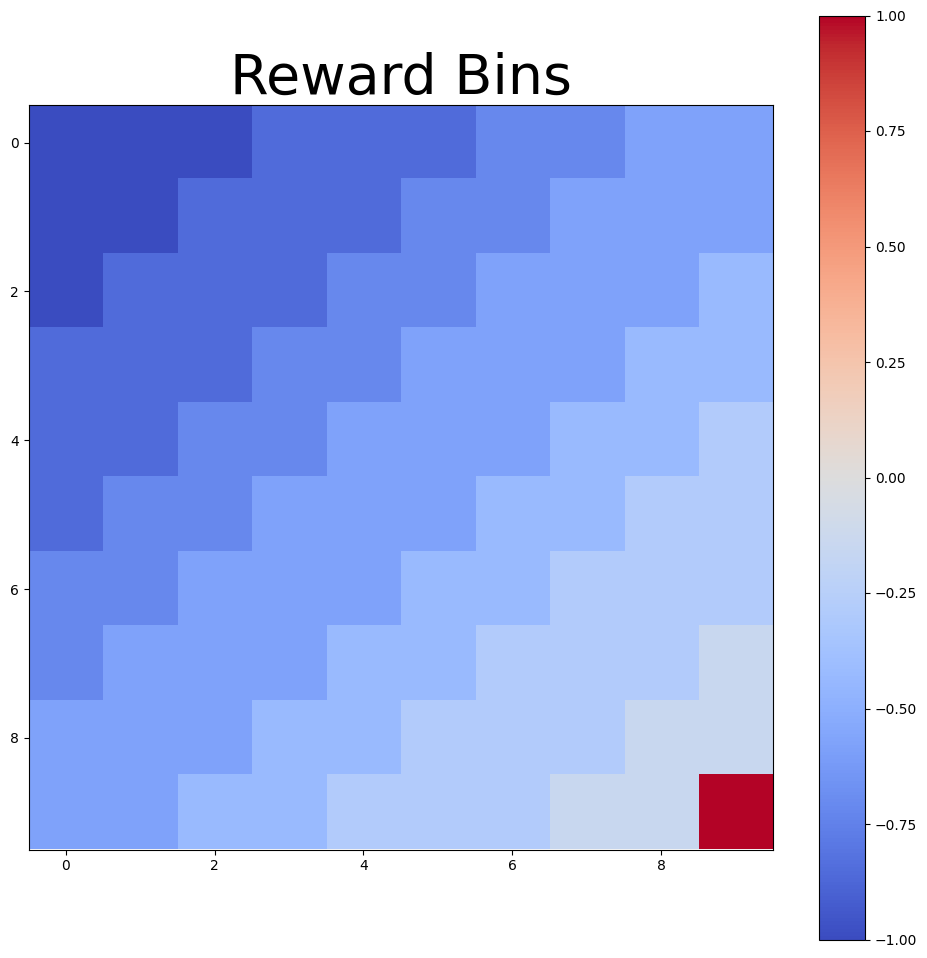

In [8]:
plt.figure(figsize=(12, 12))
plt.imshow(rewards, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Reward Bins', fontsize=40)
plt.show()


In [9]:
frame = env.render()

In [10]:
from PIL import Image
# Convert the frame to an image and save it
if isinstance(frame, np.ndarray):
    image = Image.fromarray(frame)
    image.save('./overleaf_plots/frozen_lake_env_bins.png')
else:
    print("Failed to capture frame. Ensure the render_mode is set to 'rgb_array'.")

In [ ]:
pi = get_softmax_policy(experiment_results[0]["thetas"][-1], 1e-3)


In [ ]:

tmdp.update_tau(0.)
tmdp.reset()
done = False
step = 0
env.render_mode = "human"
while True:
    s = tmdp.env.s
    a = select_action(pi[s])
    s_prime, reward, flags, prob = tmdp.step(a)
    print("state {} action {} next state {} reward {}".format(s, a, s_prime, reward))
    if flags["done"]:
        tmdp.reset()
        break
    step +=1
    if step > min(100,nrows*3):
        break
